In [ ]:
import json
import random
#import ollama
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import openai
import numpy as np
import random
#import llama_models
from scipy.stats import spearmanr
import ollama
# from datasets import load_metric
from bert_score import score
from evaluate import load
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Set your OpenAI API key
openai.api_key = ""
# Load JSONL data
def load_jsonl(file_path):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

# Reconstruct SQL query from dataset
def reconstruct_query(entry, tables_map):
    table = tables_map[entry['table_id']]
    headers = table['header']
    sql = entry['sql']
    
    select_column = headers[sql['sel']]
    aggregation = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"][sql['agg']]
    conditions = sql['conds']
    
    query = f"SELECT {aggregation}({select_column})".strip()
    if conditions:
        condition_clauses = []
        for col_index, operator, value in conditions:
            col_name = headers[col_index]
            operators = ["=", ">", "<", "OP"][operator]
            condition_clauses.append(f"{col_name} {operators} {value}")
        query += " WHERE " + " AND ".join(condition_clauses)
    return query

# Generate prompt for the LLM
def generate_prompt(sql_query):
    prompt = f"""
    Translate the following SQL query into natural language: {sql_query}.
    Include only the most possible translation and do not innclude any reasoning.
    """
    return prompt

# Compute BLEU scores
def compute_bleu(reference, candidate):
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    smoothing_function = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothing_function)

def compute_bertscore(pairs):
    questions = [item.get("question") for item in pairs]
    replies = [item.get("gpt_reply") for item in pairs if "gpt_reply" in item]
    bertscore = load("bertscore")
    results = bertscore.compute(predictions=replies, references=questions, model_type="distilbert-base-uncased")
    return results['f1'][0]

def sql2nl(dev_path, tables_path, model):
    # Load datasets
    dev_data = load_jsonl(dev_path)
    tables_data = load_jsonl(tables_path)

    # Map table_id to table metadata
    tables_map = {table['id']: table for table in tables_data}

    # Evaluate LLM on dev data
    results = []

    # Sample 10 examples for evaluation
    sampled_entries = random.sample(dev_data, 100)
    print(len(dev_data))
    for entry in sampled_entries:
        sql_query = reconstruct_query(entry, tables_map)
        prompt = generate_prompt(sql_query)
        #You are an expert in SQL and natural language translation.
        #Translate SQL to natural language with high accuracy.
        #Translate SQL queries into natural language descriptions.

        if model == "llama":
            response = ollama.chat(
                model="llama3.2",
                messages=[
                    {"role": "system", "content": "You are an expert in SQL and natural language translation."},
                    {"role": "user", "content": prompt}
                ],
            )
            gpt_reply = response["message"]["content"]

        elif model == "gpt-4o":
            response = openai.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are an expert in SQL and natural language translation."},
                    {"role": "user", "content": prompt}
                ]
            )
            # Extract and parse the suggested parameters
            gpt_reply = response.choices[0].message.content



        elif model == "gpt-3.5-turbo":
            response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                    {"role": "system", "content": "You are an expert in SQL and natural language translation."},
                    {"role": "user", "content": prompt}
            ]
            )
            gpt_reply = response.choices[0].message.content  

        
        elif model == "gpt-4":
            response = openai.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert in SQL and natural language translation."},
                {"role": "user", "content": prompt}
            ]
            )
            # Extract and parse the suggested parameters
            gpt_reply = response.choices[0].message.content
    

        # Append results
        results.append({
            "question": entry["question"],
            "sql_query": sql_query,
            "gpt_reply": gpt_reply
        })

    # Display evaluation results
    for res in results:
        print(f"Original Question: {res['question']}")
        print(f"SQL Query: {res['sql_query']}")
        print(f"LLM Reply: {res['gpt_reply']}")
        print("-" * 50)

    # Calculate BLEU scores for each result
    bleu_scores = [
        compute_bleu(res["question"], res["gpt_reply"])
        for res in results
    ]

    # Display BLEU scores
    for i, score in enumerate(bleu_scores):
        print(f"Example {i+1} BLEU Score: {score:.2f}")
        

    # Calculate and display average BLEU score
    average_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f"Average BLEU Score: {average_bleu:.2f}")
    return average_bleu, bleu_scores, results




/home/qic69/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/qic69/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2024-11-21 13:48:00.417232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 13:48:00.417261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 13:48:00.418275: E external/local_xla/xla/stream_execu

In [2]:
# Define paths to the dataset files
dev_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.jsonl"
tables_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.tables.jsonl"
model = "gpt-4o"

average_bleu_gpt4o, bleu_scores_gpt4o, results_gpt4o = sql2nl(dev_path, tables_path, model)
bert_scores_gpt4o = compute_bertscore(results_gpt4o)
print(bert_scores_gpt4o)


8421


Using the latest cached version of the module from /home/qic69/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bertscore/cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Tue Nov 19 11:03:21 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.


Original Question: Name the first elected for jacob markell
SQL Query: SELECT (First elected) WHERE Incumbent = Jacob Markell
LLM Reply: Retrieve the first elected year for the incumbent named Jacob Markell.
--------------------------------------------------
Original Question: Which score's game was less than 69 when the march was bigger than 2 and the opponents were the New York Islanders?
SQL Query: SELECT (Score) WHERE Game < 69 AND March > 2 AND Opponent = new york islanders
LLM Reply: Select the score where the game number is less than 69, the month is after February, and the opponent is the New York Islanders.
--------------------------------------------------
Original Question: What is the average Total Freshwater Withdrawal (km 3 /yr), when Industrial Use (m 3 /p/yr)(in %) is 337(63%), and when Per Capita Withdrawal (m 3 /p/yr) is greater than 535?
SQL Query: SELECT AVG(Total Freshwater Withdrawal (km 3 /yr)) WHERE Industrial Use (m 3 /p/yr)(in %) = 337(63%) AND Per Capita With

In [3]:
print(bert_scores_gpt4o)

0.8989600539207458


In [2]:
# Define paths to the dataset files
dev_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.jsonl"
tables_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.tables.jsonl"
model = "llama"

average_bleu_llama, bleu_scores_llama, results_llama = sql2nl(dev_path, tables_path, model)
bert_scores_llama = compute_bertscore(results_llama)


8421


Using the latest cached version of the module from /home/qic69/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bertscore/cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Tue Nov 19 11:03:21 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.


Original Question: what tims is wed may 28 and mon may 26 is 17' 58.34 125.960mph?
SQL Query: SELECT (Wed 28 May) WHERE Mon 26 May = 17' 58.34 125.960mph
LLM Reply: Please find the translation of the given SQL query:

On Wednesday, May 28, retrieve data where on Monday, May 26, it was 17:58.34 with a speed of 125.960mph.
--------------------------------------------------
Original Question:  november 3 where march 27-29 is 149?
SQL Query: SELECT (November 3) WHERE March 27-29 = 149
LLM Reply: Find all events on November 3 that take place during the period of March 27 to March 29.
--------------------------------------------------
Original Question: How many different players did the most high assists on the March 4 game?
SQL Query: SELECT COUNT(High assists) WHERE Date = March 4
LLM Reply: How many high assists occurred on March 4?
--------------------------------------------------
Original Question: How many passengers (in millions) flew from Seoul in 2012?
SQL Query: SELECT (2012 Pass

In [3]:
print(bert_scores_llama)

0.7757601737976074


In [6]:
# Define paths to the dataset files
dev_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.jsonl"
tables_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.tables.jsonl"
#dev_path = "D:\DMM_project-main\dev.jsonl"
#tables_path = "D:\DMM_project-main\dev.tables.jsonl"
model = "gpt-3.5-turbo"

average_bleu_gpt35t, bleu_scores_gpt35t, results_gpt35t = sql2nl(dev_path, tables_path, model)
bert_scores_gpt35t = compute_bertscore(results_gpt35t)
print(bert_scores_gpt35t)

8421


Using the latest cached version of the module from /home/qic69/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bertscore/cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Tue Nov 19 11:03:21 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.


Original Question: Which Centennial has a Altadeña of panthers?
SQL Query: SELECT (Centennial) WHERE Altadeña = panthers
LLM Reply: Retrieve the Centennial when Altadeña is panthers.
--------------------------------------------------
Original Question: What is the highest Goals Against, when Club is "Pontevedra CF", and when Played is less than 38?
SQL Query: SELECT MAX(Goals against) WHERE Club = pontevedra cf AND Played < 38
LLM Reply: Find the highest number of goals conceded by Pontevedra CF when they played fewer than 38 matches.
--------------------------------------------------
Original Question: Who was the supporting actress in "For Whom the Bell Tolls"?
SQL Query: SELECT (Supporting Actress) WHERE Film = For Whom the Bell Tolls
LLM Reply: Show me the supporting actress of the film "For Whom the Bell Tolls".
--------------------------------------------------
Original Question: WHAT IS THE SUM PLAYED WITH POINTS 1 OF 53, AND POSITION LARGER THAN 3?
SQL Query: SELECT SUM(Played)

In [7]:
# Define paths to the dataset files
dev_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.jsonl"
tables_path = "/home/qic69/Desktop/domain_metric/DMM_project/WikiSQL/data/dev.tables.jsonl"
#dev_path = "D:\DMM_project-main\dev.jsonl"
#tables_path = "D:\DMM_project-main\dev.tables.jsonl"
model = "gpt-4"

average_bleu_gpt4, bleu_scores_gpt4, results_gpt4 = sql2nl(dev_path, tables_path, model)
bert_scores_gpt4 = compute_bertscore(results_gpt4)
print(bert_scores_gpt4)

8421


Using the latest cached version of the module from /home/qic69/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--bertscore/cf4907b18f8f741f202232c0f8009a3bd49ff98802c245abcb6ea51a37a8c05b (last modified on Tue Nov 19 11:03:21 2024) since it couldn't be found locally at evaluate-metric--bertscore, or remotely on the Hugging Face Hub.


Original Question: what player is playing on round 1
SQL Query: SELECT (Player) WHERE Round = 1
LLM Reply: Select the player who participated in round 1.
--------------------------------------------------
Original Question: How many games have 23 goals with a rank greater than 9?
SQL Query: SELECT COUNT(Games) WHERE Goals = 23 AND Rank > 9
LLM Reply: Count the number of games where the goals equal 23 and the rank is greater than 9.
--------------------------------------------------
Original Question: What is the sum of the pick from texas a&i college with a round greater than 1?
SQL Query: SELECT SUM(Pick) WHERE College = texas a&i AND Round > 1
LLM Reply: Get the total sum of picks for those entries where the college is Texas A&I and the round number is greater than 1.
--------------------------------------------------
Original Question: Which Games had a Name of manuel felix diaz?
SQL Query: SELECT (Games) WHERE Name = manuel felix diaz
LLM Reply: Show the games where the name is Man

# Plot Results

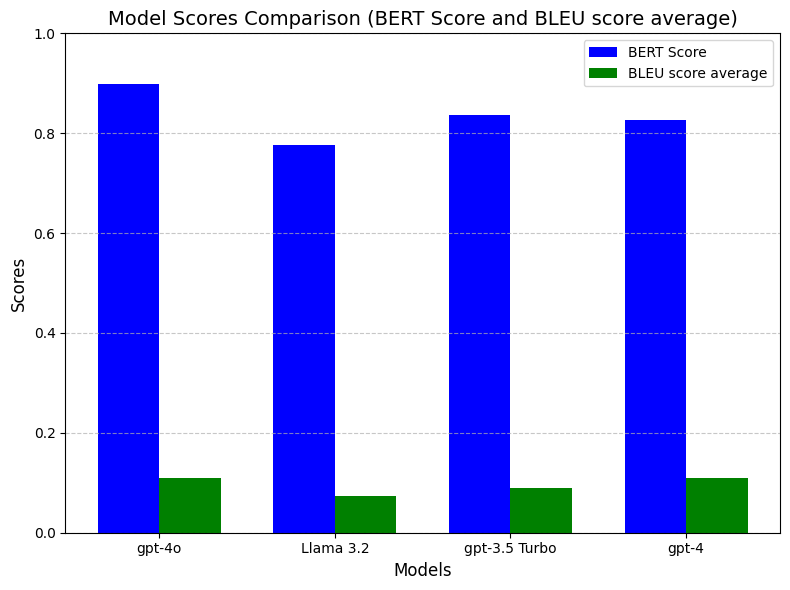

In [10]:
import matplotlib.pyplot as plt
bert_scores_gpt4o = 0.8989600539207458
average_bleu_gpt4 = 0.11
# Example scores and model names
model_names = ["gpt-4o", "Llama 3.2", "gpt-3.5 Turbo", "gpt-4"]
model_scores1 = [bert_scores_gpt4o, bert_scores_llama, bert_scores_gpt35t, bert_scores_gpt4]
model_scores2 = [average_bleu_gpt4, average_bleu_llama, average_bleu_gpt35t, average_bleu_gpt4]
# Bar width and positions
bar_width = 0.35
x_positions = range(len(model_names))

# Create the grouped bar chart
plt.figure(figsize=(8, 6))
plt.bar(x_positions, model_scores1, width=bar_width, label="BERT Score", color='b')
plt.bar([pos + bar_width for pos in x_positions], model_scores2, width=bar_width, label="BLEU score average", color='g')

# Customizing the chart
plt.xticks([pos + bar_width / 2 for pos in x_positions], model_names)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Model Scores Comparison (BERT Score and BLEU score average)", fontsize=14)
plt.ylim(0, 1)  # Assuming scores are normalized between 0 and 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()